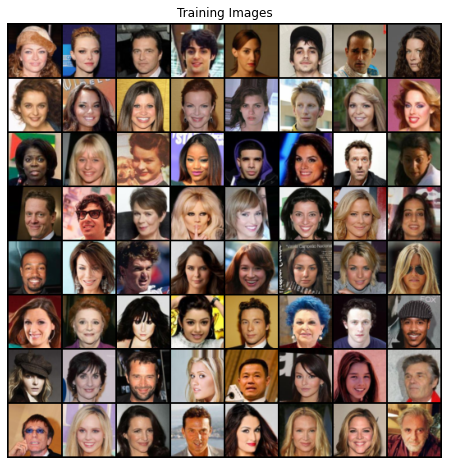

In [1]:
from __future__ import print_function
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt

# dataset: http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html

# Root directory for dataset
dataroot = "data/celeba"

# Batch size during training
batch_size = 128

# image_size
image_size = 64

# Number of training epochs
num_epochs = 5

# Learning rate for optimizers
lr = 0.0002

# Beta1 hyperparam for Adam optimizers
beta1 = 0.5

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1

# We can use an image folder dataset the way we have it setup.
# Create the dataset
dataset = dset.ImageFolder(root=dataroot,
                           transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize(
                                   (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))
# Create the dataloader
dataloader = torch.utils.data.DataLoader(
    dataset, batch_size=batch_size, shuffle=True)

# Decide which device we want to run on
device = torch.device("cuda:0" if (
    torch.cuda.is_available() and ngpu > 0) else "cpu")

# Plot some training images
real_batch = next(iter(dataloader))
plt.figure(figsize=(8, 8))
plt.axis("off")
# real_batch[0].size() torch.Size([128, 3, 64, 64])
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[
           :64], padding=2, normalize=True).cpu(), (1, 2, 0)))

In [2]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)


class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.stack = nn.Sequential(
            # [Batch, C, H, W]
            # [Batch, 100, 1, 1] -> [Batch, 512, 4, 4]
            nn.ConvTranspose2d(in_channels=100, out_channels=512,
                               kernel_size=4, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(num_features=512),
            nn.ReLU(inplace=True),

            # [Batch, 512, 4, 4] -> [Batch, 256, 8, 8]
            nn.ConvTranspose2d(in_channels=512, out_channels=256,
                               kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(num_features=256),
            nn.ReLU(inplace=True),

            # [Batch, 256, 8, 8] -> [Batch, 128, 16, 16]
            nn.ConvTranspose2d(in_channels=256, out_channels=128,
                               kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(num_features=128),
            nn.ReLU(inplace=True),


            # [Batch, 128, 16, 16] -> [Batch, 64, 32, 32]
            nn.ConvTranspose2d(in_channels=128, out_channels=64,
                               kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(num_features=64),
            nn.ReLU(inplace=True),

            # [Batch, 64, 32, 32] -> [Batch, 3, 64, 64]
            nn.ConvTranspose2d(in_channels=64, out_channels=3,
                               kernel_size=4, stride=2, padding=1, bias=False),
            nn.Tanh()
        )

    def forward(self, input):
        return self.stack(input)

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.stack = nn.Sequential(
            #  image input  [Batch, 3, 64, 64]  ->  [Batch, 64, 32, 32]
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=4,
                      stride=2, padding=1, bias=False),
            nn.BatchNorm2d(num_features=64),
            nn.LeakyReLU(0.2, inplace=True),

            #  [Batch, 64, 32, 32] -> [Batch, 128, 16, 16]
            nn.Conv2d(in_channels=64, out_channels=128,
                      kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(num_features=128),
            nn.LeakyReLU(0.2, inplace=True),

            #  [Batch, 128, 16, 16] -> [Batch, 256, 8, 8]
            nn.Conv2d(in_channels=128, out_channels=256,
                      kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(num_features=256),
            nn.LeakyReLU(0.2, inplace=True),

            # [Batch, 256, 8, 8] -> [Batch, 512, 4, 4]
            nn.Conv2d(in_channels=256, out_channels=512,
                      kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(num_features=512),
            nn.LeakyReLU(0.2, inplace=True),

            #  [Batch, 512, 4, 4]  -> [Batch, 1, 1, 1]
            nn.Conv2d(in_channels=512, out_channels=1, kernel_size=4,
                      stride=1, padding=0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.stack(input)


# Create the Discriminator
netD = Discriminator().to(device)

# Create the generator
netG = Generator().to(device)

# Apply the weights_init function to randomly initialize all weights
netD.apply(weights_init)

# Apply the weights_init function to randomly initialize all weights
netG.apply(weights_init)

# Print the model
print(netD)

# Print the model
print(netG)

Discriminator(
  (stack): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
    (3): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.2, inplace=True)
    (6): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): LeakyReLU(negative_slope=0.2, inplace=True)
    (9): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): LeakyReLU(negative_slope=0.2, inplace=True)
    (12): Conv2d(512, 1, kernel_size=

Starting Training Loop...
[0/5][0/1583]
[0/5][50/1583]
[0/5][100/1583]
[0/5][150/1583]
[0/5][200/1583]
[0/5][250/1583]
[0/5][300/1583]
[0/5][350/1583]
[0/5][400/1583]
[0/5][450/1583]
[0/5][500/1583]
[0/5][550/1583]
[0/5][600/1583]
[0/5][650/1583]
[0/5][700/1583]
[0/5][750/1583]
[0/5][800/1583]
[0/5][850/1583]
[0/5][900/1583]
[0/5][950/1583]
[0/5][1000/1583]
[0/5][1050/1583]
[0/5][1100/1583]
[0/5][1150/1583]
[0/5][1200/1583]
[0/5][1250/1583]
[0/5][1300/1583]
[0/5][1350/1583]
[0/5][1400/1583]
[0/5][1450/1583]
[0/5][1500/1583]
[0/5][1550/1583]
[1/5][0/1583]
[1/5][50/1583]
[1/5][100/1583]
[1/5][150/1583]
[1/5][200/1583]
[1/5][250/1583]
[1/5][300/1583]
[1/5][350/1583]
[1/5][400/1583]
[1/5][450/1583]
[1/5][500/1583]
[1/5][550/1583]
[1/5][600/1583]
[1/5][650/1583]
[1/5][700/1583]
[1/5][750/1583]
[1/5][800/1583]
[1/5][850/1583]
[1/5][900/1583]
[1/5][950/1583]
[1/5][1000/1583]
[1/5][1050/1583]
[1/5][1100/1583]
[1/5][1150/1583]
[1/5][1200/1583]
[1/5][1250/1583]
[1/5][1300/1583]
[1/5][1350/1583]


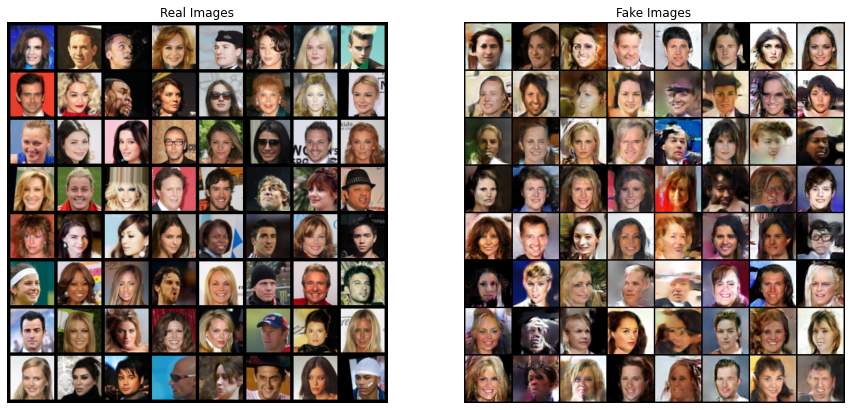

In [3]:
# Initialize BCELoss function default reduction='mean'
import time
criterion = nn.BCELoss()

# Create batch of latent vectors that we will use to visualize
# the progression of the generator [Batch, 100, 1, 1]
fixed_noise = torch.randn(64, 100, 1, 1, device=device)

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

# Training Loop
img_list = []
iters = 0

start = time.time()
print("Starting Training Loop...")
for epoch in range(num_epochs):

    # For each batch in the dataloader
    for i, data in enumerate(dataloader, 0):

        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################

        # Train with all-real batch -> maximize log(D(x)) -> BCELOSS = -log(D(x)) when using label = 1, optimizer will minimize BCELOSS and therefore maximize log(D(x))
        optimizerD.zero_grad()
        real_batch = data[0].to(device)  # torch.Size([128, 3, 64, 64]))
        batch_sz = real_batch.size(0)
        labels = torch.full((batch_sz,), 1, dtype=torch.float,
                            device=device)  # [128,]

        # output [128, 1, 1, 1])) so flatten it to [128,]
        real_output = netD(real_batch).view(-1)
        real_loss = criterion(real_output, labels)
        real_loss.backward()

        # Train with all-fake batch -> maximize log(1 - D(G(z))) -> BCELOSS = -log(1-D(G(z))) when using label = 0, optimizer will minimize BCELOSS and therefore maximize log(1-D(G(z)))
        
        # generate z with size [128, 100, 1, 1]
        z = torch.randn(batch_sz, 100, 1, 1,
                        device=device)

        # G(z) [128, 3, 64, 64]
        fake_batch = netG(z)

        # flatten output [128, 1, 1, 1])) to [128,] & detach fake_batch to maintain gradients of G(z) otherwise they would be cleared
        fake_output = netD(fake_batch.detach()).view(-1)
        labels.fill_(0)
        fake_loss = criterion(fake_output, labels)
        fake_loss.backward()

        # Update D
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################

        optimizerG.zero_grad()

        # flatten output [128, 1, 1, 1])) to [128,]
        fake_output = netD(fake_batch).view(-1)
        labels.fill_(1)
        fake_loss = criterion(fake_output, labels)
        fake_loss.backward()

        # Update G
        optimizerG.step()

        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]' % (epoch, num_epochs, i, len(dataloader)))

        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                # [64, 3, 64, 64] 64 sample images
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))
        iters += 1

print("Finished Training, takes %d seconds..." % (time.time() - start))

# Grab a batch of real images from the dataloader
real_batch = next(iter(dataloader))

# Plot the real images
plt.figure(figsize=(15, 15))
plt.subplot(1, 2, 1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[
           :64], padding=5, normalize=True).cpu(), (1, 2, 0)))

# Plot the fake images from the last epoch
plt.subplot(1, 2, 2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1], (1, 2, 0)))
plt.show()

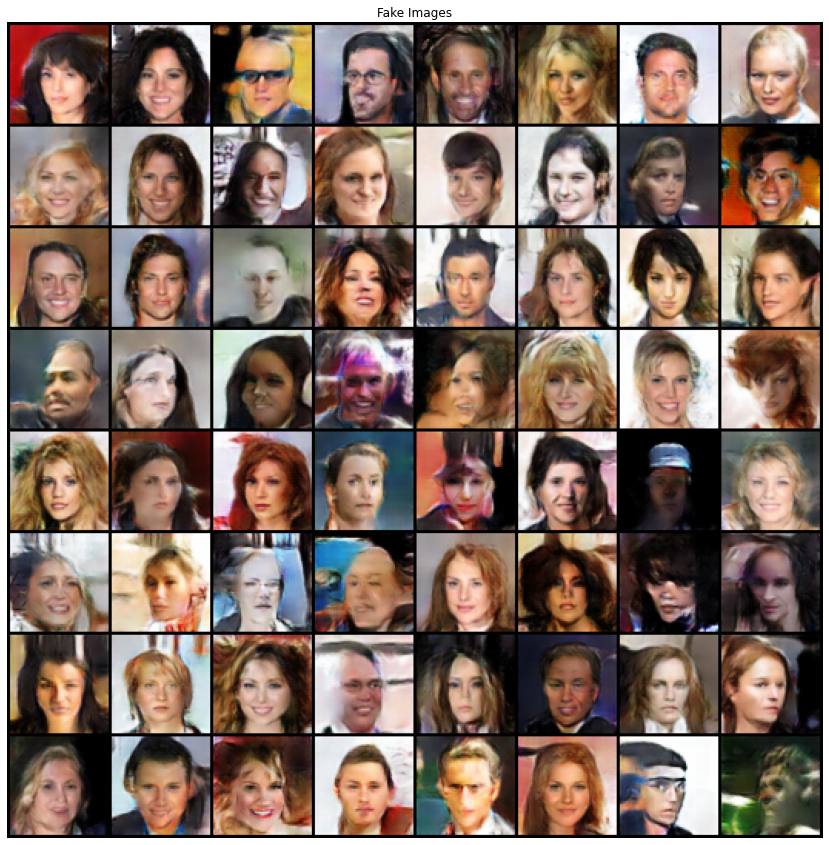

In [12]:
# Plot the real images
random_noise = torch.randn(64, 100, 1, 1, device=device)
fake = netG(random_noise).detach().cpu()
fake_imgs = vutils.make_grid(fake, padding=2, normalize=True)
plt.figure(figsize=(15, 15))
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(fake_imgs, (1, 2, 0)))
plt.show()

In [13]:
from pathlib import Path
MODEL_PATH = Path("model") / "dcgan"
torch.save(netG.state_dict(), MODEL_PATH / "dcgan_gpu_model.pt")